In [1]:
import os
import glob

import numpy as np
import scipy.ndimage

import astropy.io.fits as fits

%matplotlib inline
import matplotlib.pyplot as plt

import pyccl as ccl

import baryon_painter.painter
import baryon_painter.process_SLICS

import cosmotools.pseudo_Cls

pi = np.pi

In [2]:
import importlib

Load the generative model here

In [3]:
painter_cvae = baryon_painter.painter.CVAEPainter(("../data/checkpoints/single_scale_max_z2_log_shift_softmax_lr1e-3/model_state",
                                                   "../data/checkpoints/single_scale_max_z2_log_shift_softmax_lr1e-3/model_meta"))


CVAE with Type-1 architecture.


In [4]:
def create_y_map(painted_planes, z, resolution, map_size, cosmo, order=3):
    y_map = np.zeros((resolution, resolution))
    
    h = cosmo.params.parameters.h
    d_A = ccl.comoving_angular_distance(cosmo, 1/(1+np.array(z)))
    d_A = np.append(d_A, d_A[-1] + 252.5/h)
    
    d_A_eff = d_A[:-1] # z is already the slice mid-point
    a_eff = np.array([ccl.scale_factor_of_chi(cosmo, d) for d in d_A_eff])
    
    y_fac = 8.125561e-16 # sigma_T/m_e*c^2 in SI
    mpc = 3.086e22 # m/Mpc
    eV = 1.60218e-19 # Electronvolt in Joules
    cm = 0.01 # Centimetre in metres

    Xe = 1.17
    Xi = 1.08
    
    V_c = (400/h/2048*mpc/cm)**3 # Volume of cell in cm^3
    y_fac = y_fac*eV*mpc**-2 # sigma_T/m_e*c^2 in Mpc^2 eV^-1
    
    theta_pix = map_size/resolution*pi/180 # Pixel size in radians
    L_pix = theta_pix*d_A_eff*a_eff # Physical pixel size in Mpc
    
    for i, d in enumerate(painted_planes):
        zoom_factor = resolution/d.shape[0]
        d = d.copy()
        d[np.isnan(d)] = 0
        
        d *= V_c*(Xe+Xi)/Xe*y_fac/L_pix[i]**2/zoom_factor**2
        print(f"z : {z[i]:0.3f}, plane shape: {d.shape}, zoom_factor: {zoom_factor:0.3f}")
        print(f"{np.isnan(d).sum()}")
        
        y_map += scipy.ndimage.zoom(d, zoom=zoom_factor, order=order, mode="mirror")
        
    return y_map


In [13]:
importlib.reload(baryon_painter.process_SLICS)

SLICS_filenames = glob.glob("../data/training_data/SLICS/delta/*delta.dat_bicubic_LOS1097")

# These are the redshifts of the mid-points of the slices
z_SLICS = [float(z[:z.find("delta")]) for z in [os.path.split(f)[1] for f in SLICS_filenames]]
z_SLICS = np.array(sorted(z_SLICS))

Omega_m = 0.2905
Omega_b = 0.0473
Omega_L = 0.7095
h = 0.6898
sigma_8 = 0.826
n_s = 0.969
cosmo_SLICS = ccl.Cosmology(Omega_c=(1-Omega_L-Omega_b), Omega_b=Omega_b, Omega_k=0,
                            h=h, sigma8=sigma_8, n_s=n_s, m_nu=0.0)

d_A_SLICS = ccl.comoving_angular_distance(cosmo_SLICS, 1/(1+z_SLICS))*h # units of Mpc/h

# Physical redshift of the slices
z_slice = np.array([1/ccl.scale_factor_of_chi(cosmo_SLICS, 252.5/h*i) - 1 for i in range(len(z_SLICS))])

n_z = 10

painted_planes = {}

for LOS in [401, 400, 1097]:
    painted_planes[LOS] = baryon_painter.process_SLICS.process_SLICS(
                                   painter_cvae, 
                                   tile_size=100.0, n_pixel_tile=512,
                                   LOS=LOS, 
                                   z_SLICS=z_SLICS[:n_z], delta_size=d_A_SLICS[:n_z]*10/180*pi, 
                                   delta_path="../data/training_data/SLICS/delta/", 
                                   massplane_path="../data/training_data/SLICS/massplanes/", 
                                   shifts_path="../data/training_data/SLICS/random_shifts/",
                                   z_slice=z_slice[:n_z],
                                   min_tiling_overlap=0.2,
                                   regularise=False,
                                   regularise_std=None
                                )
    


Processing z=0.042
  Tile bigger than delta plane, using mass planes.
  Loading ../data/training_data/SLICS/massplanes/0.042proj_half_finer_xy.dat_LOS401.
  Extracting tile.
  Painting on tile.
Processing z=0.130
  Tile bigger than delta plane, using mass planes.
  Loading ../data/training_data/SLICS/massplanes/0.130proj_half_finer_xz.dat_LOS401.
  Extracting tile.
  Painting on tile.
Processing z=0.221
  Using 2 tiles (on each side)
    Painting on tile 1-1
    Painting on tile 1-2
    Painting on tile 2-1
    Painting on tile 2-2
Processing z=0.317
  Using 3 tiles (on each side)
    Painting on tile 1-1
    Painting on tile 1-2
    Painting on tile 1-3
    Painting on tile 2-1
    Painting on tile 2-2
    Painting on tile 2-3
    Painting on tile 3-1
    Painting on tile 3-2
    Painting on tile 3-3
Processing z=0.418
  Using 3 tiles (on each side)
    Painting on tile 1-1
    Painting on tile 1-2
    Painting on tile 1-3
    Painting on tile 2-1
    Painting on tile 2-2
    Painting

    Painting on tile 5-2
    Painting on tile 5-3
    Painting on tile 5-4
    Painting on tile 5-5
Processing z=0.764
  Using 6 tiles (on each side)
    Painting on tile 1-1
    Painting on tile 1-2
    Painting on tile 1-3
    Painting on tile 1-4
    Painting on tile 1-5
    Painting on tile 1-6
    Painting on tile 2-1
    Painting on tile 2-2
    Painting on tile 2-3
    Painting on tile 2-4
    Painting on tile 2-5
    Painting on tile 2-6
    Painting on tile 3-1
    Painting on tile 3-2
    Painting on tile 3-3
    Painting on tile 3-4
    Painting on tile 3-5
    Painting on tile 3-6
    Painting on tile 4-1
    Painting on tile 4-2
    Painting on tile 4-3
    Painting on tile 4-4
    Painting on tile 4-5
    Painting on tile 4-6
    Painting on tile 5-1
    Painting on tile 5-2
    Painting on tile 5-3
    Painting on tile 5-4
    Painting on tile 5-5
    Painting on tile 5-6
    Painting on tile 6-1
    Painting on tile 6-2
    Painting on tile 6-3
    Painting on tile 6-4


    Painting on tile 6-7
    Painting on tile 7-1
    Painting on tile 7-2
    Painting on tile 7-3
    Painting on tile 7-4
    Painting on tile 7-5
    Painting on tile 7-6
    Painting on tile 7-7
Processing z=1.041
  Using 8 tiles (on each side)
    Painting on tile 1-1
    Painting on tile 1-2
    Painting on tile 1-3
    Painting on tile 1-4
    Painting on tile 1-5
    Painting on tile 1-6
    Painting on tile 1-7
    Painting on tile 1-8
    Painting on tile 2-1
    Painting on tile 2-2
    Painting on tile 2-3
    Painting on tile 2-4
    Painting on tile 2-5
    Painting on tile 2-6
    Painting on tile 2-7
    Painting on tile 2-8
    Painting on tile 3-1
    Painting on tile 3-2
    Painting on tile 3-3
    Painting on tile 3-4
    Painting on tile 3-5
    Painting on tile 3-6
    Painting on tile 3-7
    Painting on tile 3-8
    Painting on tile 4-1
    Painting on tile 4-2
    Painting on tile 4-3
    Painting on tile 4-4
    Painting on tile 4-5
    Painting on tile 4-6


In [15]:
y_map = {}

for LOS in painted_planes.keys():
    y_map[LOS] = create_y_map(painted_planes[LOS][:], z_SLICS[:n_z], 
                              resolution=7745//5, map_size=10.0, cosmo=cosmo_SLICS, order=5)

z : 0.042, plane shape: (111, 111), zoom_factor: 13.955
0
z : 0.130, plane shape: (338, 338), zoom_factor: 4.583
0
z : 0.221, plane shape: (562, 562), zoom_factor: 2.756
0
z : 0.317, plane shape: (787, 787), zoom_factor: 1.968
0
z : 0.418, plane shape: (1012, 1012), zoom_factor: 1.531
0
z : 0.525, plane shape: (1236, 1236), zoom_factor: 1.253
0
z : 0.640, plane shape: (1462, 1462), zoom_factor: 1.060
0
z : 0.764, plane shape: (1689, 1689), zoom_factor: 0.917
0
z : 0.897, plane shape: (1915, 1915), zoom_factor: 0.809
0
z : 1.041, plane shape: (2140, 2140), zoom_factor: 0.724
0
z : 0.042, plane shape: (111, 111), zoom_factor: 13.955
0
z : 0.130, plane shape: (338, 338), zoom_factor: 4.583
0
z : 0.221, plane shape: (562, 562), zoom_factor: 2.756
0
z : 0.317, plane shape: (787, 787), zoom_factor: 1.968
0
z : 0.418, plane shape: (1012, 1012), zoom_factor: 1.531
0
z : 0.525, plane shape: (1236, 1236), zoom_factor: 1.253
0
z : 0.640, plane shape: (1462, 1462), zoom_factor: 1.060
0
z : 0.764, 

Plot the painted slices

Text(0, 0.5, 'Painted pressure')

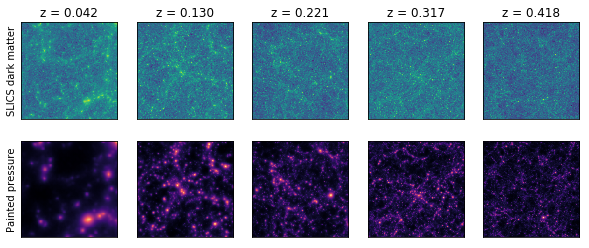

In [17]:
LOS = 1097
n_plane = 5#len(painted_planes[LOS])

fig, ax = plt.subplots(2, n_plane, figsize=(10, 4))

cmap = plt.get_cmap("magma")

for i in range(n_plane):
    delta = np.fromfile(f"../data/training_data/SLICS/delta/{z_SLICS[i]:.3f}delta.dat_bicubic_LOS{LOS}", 
                        dtype=np.float32).reshape(7745, -1).T
    delta = delta[::7,::7] + 96
    
    ax[0,i].imshow(np.log(delta + 1), extent=(0,d_A_SLICS[i]*10/180*pi, 0,d_A_SLICS[i]*10/180*pi))
    ax[1,i].imshow(np.log(painted_planes[LOS][i]+0.01), cmap=cmap, 
                   extent=(0,d_A_SLICS[i]*10/180*pi, 0,d_A_SLICS[i]*10/180*pi))
        
    ax[0,i].set_title(f"z = {z_SLICS[i]:.3f}")

[p.set_xticks([]) for p in ax.flatten()]
[p.set_yticks([]) for p in ax.flatten()]

ax[0,0].set_ylabel("SLICS dark matter")
ax[1,0].set_ylabel("Painted pressure")
# fig.savefig("../plots/painted_SLICS.pdf", transparent=True)

Plot the Cls

In [18]:
Cl = {}
for LOS in y_map.keys():
    Cl[LOS] = {}
    
    kappa_map = np.fromfile(f"../data/training_data/SLICS/kappa/KiDS450/kappa_KiDS450_tomo0.dat_LOS{LOS}", dtype=np.float32).reshape(7745, -1, order="F")
    kappa_map *= 64
    Cl[LOS]["shear-y"], _, ell, _, _ = cosmotools.pseudo_Cls.calculate_pseudo_Cl(
                                                  y_map[LOS], kappa_map[::5,::5], 
                                                  box_size=(10/180*pi, 10/180*pi),
                                                  n_bin=16, ell_min=36, ell_max=4000, logspaced=True)
    Cl[LOS]["y-y"], _, ell, _, _ = cosmotools.pseudo_Cls.calculate_pseudo_Cl(
                                                  y_map[LOS], y_map[LOS], 
                                                  box_size=(10/180*pi, 10/180*pi),
                                                  n_bin=16, ell_min=36, ell_max=4000, logspaced=True)

Cl_BAHAMAS = {"shear-y" : {}, "y-y" : {}}
Cl_BAHAMAS["shear-y"]["LOS"] = np.loadtxt("/Users/yooken/Research/project_triad/results/20190107/BAHAMAS_no_noise_no_beam/TUNED/shear_y_cl_binned/LOS_1_1.txt")
Cl_BAHAMAS["shear-y"]["mean"] = Cl_BAHAMAS["shear-y"]["LOS"].mean(axis=0)
Cl_BAHAMAS["shear-y"]["std"] = Cl_BAHAMAS["shear-y"]["LOS"].std(axis=0, ddof=1)
Cl_BAHAMAS["shear-y"]["ell"] = np.loadtxt("/Users/yooken/Research/project_triad/results/20190107/BAHAMAS_no_noise_no_beam/TUNED/y_y_cl_binned/ell.txt")

Cl_BAHAMAS["y-y"]["LOS"] = np.loadtxt("/Users/yooken/Research/project_triad/results/20190107/BAHAMAS_no_noise_no_beam/TUNED/y_y_cl_binned/LOS_1_1.txt")
Cl_BAHAMAS["y-y"]["mean"] = Cl_BAHAMAS["y-y"]["LOS"].mean(axis=0)
Cl_BAHAMAS["y-y"]["std"] = Cl_BAHAMAS["y-y"]["LOS"].std(axis=0, ddof=1)
Cl_BAHAMAS["y-y"]["ell"] = np.loadtxt("/Users/yooken/Research/project_triad/results/20190107/BAHAMAS_no_noise_no_beam/TUNED/y_y_cl_binned/ell.txt")


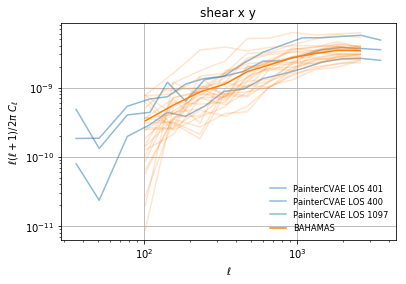

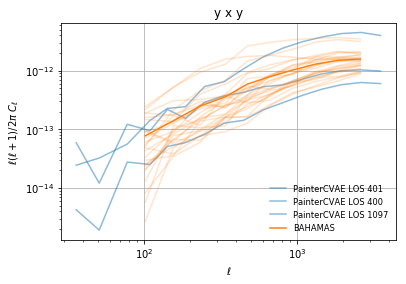

In [19]:
for probe_1 in ["shear", "y"]:
    fig, ax = plt.subplots(1,1)
    
    u = ell*(ell+1)/(2*pi)
    for LOS in Cl.keys():
        ax.plot(ell, u*Cl[LOS][f"{probe_1}-y"], c="C0", alpha=0.5, label=f"PainterCVAE LOS {LOS}")

    ell_BAHAMAS = Cl_BAHAMAS[f"{probe_1}-y"]["ell"]
    u = ell_BAHAMAS*(ell_BAHAMAS+1)/(2*pi)
    ax.plot(ell_BAHAMAS, (u*Cl_BAHAMAS[f"{probe_1}-y"]["LOS"]).T, c="C1", alpha=0.2)
    ax.plot(ell_BAHAMAS, u*Cl_BAHAMAS[f"{probe_1}-y"]["mean"], c="C1", label="BAHAMAS")

    ax.legend(fontsize="small", frameon=False)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$\ell$")
    ax.set_ylabel(r"$\ell(\ell+1)/2\pi\ C_\ell$")
    ax.grid()

    ax.set_title(f"{probe_1} x y")
    fig.savefig(f"../plots/Cl_{probe_1}-y_PainterCVAE_vs_BAHAMAS.pdf")

Plot the y map and corresponding kappa map

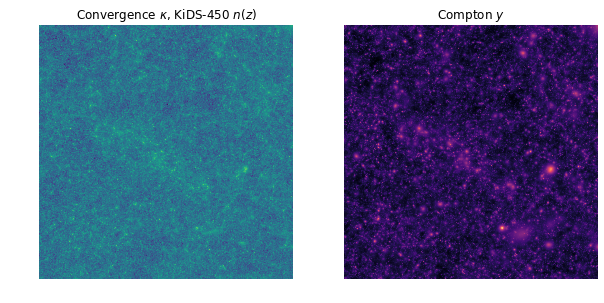

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

ax[0].imshow(np.log(kappa_map[::5,::5]/kappa_map.std()+2))
ax[1].imshow(np.log(y_map[1097]/y_map[1097].std()+0.01), cmap=plt.get_cmap("magma"))

ax[0].axis("off")
ax[0].set_title("Convergence $\kappa$, KiDS-450 $n(z)$")

ax[1].axis("off")
ax[1].set_title("Compton $y$")

fig.savefig("../plots/kappa_y_maps.pdf", pad_inches=0, bbox_inches="tight", dpi=100)

## Old histogram plots

In [ ]:
import pickle
with open("../data/training_data/BAHAMAS/stacks_uncompressed_new/train_files_info.pickle", "rb") as f:
    training_files_info = pickle.load(f)

import baryon_painter.utils.datasets as datasets

importlib.reload(datasets)
dataset = datasets.BAHAMASDataset(files=training_files_info, root_path="../data/training_data/BAHAMAS/stacks_uncompressed_new/",
                                  label_fields=["pressure"],
                                  mmap_mode="r",
                                  scale_to_SLICS=True,
                                  subtract_minimum=False,
                                 )


In [ ]:
fig, ax = plt.subplots(1, n_plane+1, figsize=(3*(n_plane+1), 3))


bins = np.logspace(-4, 1.5, 100)
for i in range(n_plane):
    ax[i].hist(painted_planes[i].flatten()*(1+z_SLICS[i])**2, bins=bins, density=True, histtype="step", label=f"z={z_SLICS[i]}")
    ax[-1].hist(painted_planes[i].flatten()*(1+z_SLICS[i])**2, bins=bins, density=True, histtype="step", label=f"z={z_SLICS[i]}")

ax[-1].set_xscale("log")
# ax[-1].set_yscale("log")
ax[-1].legend(loc="lower center", fontsize="small", frameon=False)
    
for i, z in enumerate([0.0, 0.125,0.25,0.375,0.375,0.5]):
    d, _, _ = dataset.get_batch(size=1, z=z)
    ax[i].hist(d[1].flatten()*(1+z)**2, bins=bins, density=True, histtype="step", label=f"BAHAMAS z={z}")
    
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].legend(loc="lower center", fontsize="small", frameon=False)
    

In [ ]:
fig, ax = plt.subplots(1, 2)

bins = np.logspace(-7, -3, 100)
_ = ax[0].hist(y_map[1097].flatten(), bins=bins, density=True, histtype="step")

with fits.open("../data/tSZ/BAHAMAS/AGN_TUNED_nu0_L400N1024_WMAP9_cone_2_gas_y_image_ngp.fits") as hdu:
    y_BAHAMAS = hdu[0].data[:]
    
_ = ax[0].hist(y_BAHAMAS.flatten(), bins=bins, density=True, histtype="step")

ax[0].set_xscale("log")
ax[0].set_yscale("log")

## Attempts to estimate the auto-power spectrum from the slice Cls

In [ ]:
import cosmotools.twodee.random_fields

def approximate_y_y_Cl(dataset, cosmo, ell):
    n_k_bin = 500
    h = cosmo.params.parameters.h

    z = dataset.redshifts
    
    chi = [ccl.comoving_radial_distance(cosmo, 1/(1+z_))*h for z_ in z]
    chi = np.array(chi + [chi[-1] + 250])
    a = np.array([ccl.scale_factor_of_chi(cosmo, chi_/h) for chi_ in chi])
    
    Delta_chi = chi[1:] - chi[:-1]
    a_star = (a[:-1] + a[1:])/2
    chi_star = ccl.comoving_radial_distance(cosmo, a_star)*h
    Pk_2d = np.zeros((len(z), n_k_bin))
    k_2d = np.zeros(n_k_bin)
    
    Pk_2d_intp = []
    for i in range(len(z)):
        d, _, _ = dataset.get_batch(size=1, z=z[i])
        pressure = d[1].squeeze()
        Pk_2d[i], k_2d, _, _ = cosmotools.twodee.random_fields.pseudo_Pofk(pressure, pressure, 
                                                                        L=100,
                                                                        k_min=2*pi/100,
                                                                        k_max=2*pi/100*512/2,
                                                                        n_k_bin=n_k_bin, 
                                                                        logspaced_k_bins=False
                                                                     )
        Pk_2d_intp.append(scipy.interpolate.UnivariateSpline(np.log(k_2d), np.log(Pk_2d[i]), ext=2))
        
    y_fac = 8.125561e-16 # sigma_T/m_e*c^2 in SI
    mpc = 3.086e22 # m/Mpc
    eV = 1.60218e-19 # Electronvolt in Joules
    cm = 0.01 # Centimetre in metres
    y_kernel_const = y_fac*mpc*eV*cm**-3/h
    
    Cl = np.zeros_like(ell)
    for i in range(len(z)):
        Cl += y_kernel_const**2*Delta_chi[i]/chi_star[i]**2/a_star[i]**4*np.exp(Pk_2d_intp[i](np.log(ell/chi_star[i])))/250**2
        
    
    
    return Cl

# Pk_2d, k_2d, Pk_2d_intp = approximate_y_y(dataset, cosmo)

# k = np.logspace(np.log10(k_2d[0]), np.log10(k_2d[-1]), 50)

# cmap = plt.get_cmap("tab20")
# for i in range(Pk_2d.shape[0]):
#     plt.loglog(k_2d, Pk_2d[i], c=cmap(i))

#     plt.loglog(k, np.exp(Pk_2d_intp[i](np.log(k))), ls="--", c=cmap(i))

ell_approx = np.logspace(np.log10(320), np.log10(2500), 100)
Cl_approx = approximate_y_y_Cl(dataset, cosmo, ell_approx)
plt.loglog(ell_approx, ell_approx**2*Cl_approx)